In [23]:
!pip install tab2img

2.3.0


## import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Activation,Dropout 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.utils import to_categorical

from tab2img.converter import Tab2Img

# **Read CSV files**

In [2]:
df  = pd.read_csv("dataset.csv")
df.head()

,Category of Trade,Volume/ Amount,Volume Type,Load Port,Discharge Port,Dangerous Goods,Organisation
0,7,"26,726",1,27,34,2,73
1,5,"2,600",1,44,54,2,69
2,7,"10,710",1,8,0,2,12
3,7,"21,611",1,8,40,2,12
4,7,"5,139",1,6,0,2,12


# **Seperate features and target**

In [3]:
# seperate features and target column
features = ["Category of Trade", "Volume Type", "Load Port", "Discharge Port", "Dangerous Goods"]
target = "Organisation"

# copy the feqatures and class dataframe in X and y variable
X = df[features]
y = df[target]

# **Scale features and train test split**

In [4]:
# scalling feature value between the range of 0-1
ss = StandardScaler()
X = ss.fit_transform(X)


## customize functions

In [5]:
#list of evaluation scores
evalution_scores = []

# save saller
pkl_file = open('target_encoder.pkl', 'rb')
le_target = pickle.load(pkl_file) 

# function for getting class labels via class integar using label encoder
def get_classes(y_test):
    y_test = y_test.unique()
    print(len(y_test))
    return le_target.inverse_transform(y_test)

# get unique classes in test set
def get_str_classes(y_test):
    y_test = y_test.unique()
    return [str(int) for int in y_test]

# split dataset in training and testing set 
def get_train_test_split():
    return train_test_split(X, y, test_size=0.2, random_state=42)


# split data into train, test and validation set with splitted feature and class
def get_train_test_val_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=2)
    return X_train, X_test, X_val, y_train, y_test, y_val

# split data into train, test and validation set with joined feature and class
def get_train_test_val_split_df():
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.25, random_state=2)
    return train, test, val


# compute the accuracy using true and predicted labels
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy


# compute other evaluation measures and print
def make_predictions(y_test, y_pred):
    accuracy=accuracy_score(y_test, y_pred)
    P, R, F, S = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    
    accuracy = "{:.4f}".format(accuracy)
    P = "{:.4f}".format(P)
    R = "{:.4f}".format(R)
    F = "{:.4f}".format(F)

    print("Accuracy Score :", accuracy)
    print("=======================\n")

    print("Precision Score :", P)
    print("========================\n")

    print("Recall Score :", R)
    print("=====================\n")

    print("F1 Score :", F)
    print("=================\n")

    return accuracy, P, R, F


def DL_preprocessing(train, target):
    target = target.to_numpy()
    model = Tab2Img()
    images = model.fit_transform(train, target)
    
    size = (200, 200)
    reshaped_images = []
    for img in images:
        img = np.resize(img, (img.shape[0], img.shape[1], 3))
        reshaped_images.append(tf.keras.preprocessing.image.smart_resize(
            img, size, interpolation='bilinear'
        ))
    reshaped_images = np.array(reshaped_images)
    target = tf.keras.utils.to_categorical(target, 81)
    return reshaped_images, target


def plot_graph(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# **Machine Learning Models**
## **Random Forest**

In [6]:
X_train, X_test, y_train, y_test = get_train_test_split()
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")


shape of training features : (17271, 5)

 shape of training labels : (17271,)

 shape of testing features : (4318, 5)

 shape of testing labels : (4318,)


In [7]:
# model initialization
clf = RandomForestClassifier()
# model training
clf = clf.fit(X_train, y_train)

In [8]:
# model predictions
y_pred = clf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["Random Forest", Acc, P, R, F])

Accuracy Score : 0.7913

Precision Score : 0.7867

Recall Score : 0.7913

F1 Score : 0.7644



# Gradient Boosting

In [9]:
X_train, X_test, y_train, y_test = get_train_test_split()
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")


shape of training features : (17271, 5)

 shape of training labels : (17271,)

 shape of testing features : (4318, 5)

 shape of testing labels : (4318,)


In [10]:
# model predictions
clf =  GradientBoostingClassifier()
# model training
clf = clf.fit(X_train, y_train)

In [11]:
# model predictions
y_pred = clf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["Gradient Boosting", Acc, P, R, F])

Accuracy Score : 0.6971

Precision Score : 0.7046

Recall Score : 0.6971

F1 Score : 0.6725



# **DL Models**
## **Preprocessing**

In [12]:
train, target = DL_preprocessing(X, y)

# Resnet

In [13]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_split(train, target)
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")
print("\n shape of validation features :", X_val.shape)
print("========================================")
print("\n shape of validation labels :", y_val.shape)
print("=====================================")


shape of training features : (15155, 200, 200, 3)

 shape of training labels : (15155, 81)

 shape of testing features : (2159, 200, 200, 3)

 shape of testing labels : (2159, 81)

 shape of validation features : (4275, 200, 200, 3)

 shape of validation labels : (4275, 81)


In [14]:
# input shape configure
input_t = tf.keras.Input(shape=(200, 200, 3))
res_model = tf.keras.applications.ResNet50(include_top=False, 
                    weights="imagenet", input_tensor=input_t)

for layer in res_model.layers[:143]:
    layer.trainable = False

# to_res = (224, 224)
model = tf.keras.models.Sequential()  
model.add(res_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(81, activation='softmax'))

In [50]:
# early stopping
check_point = tf.keras.callbacks.ModelCheckpoint(filepath="cifar10.h5",
                                          monitor="val_acc  ",
                                          mode="max",
                                          save_best_only=True,
                                          )

# model compilation
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
 
# model training
history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1,
                validation_data=(X_val, y_val),
                callbacks=[check_point])

Epoch 1/10
60/60 [==============================] - 1332s 22s/step - loss: 2.7886 - accuracy: 0.3295 - val_loss: 4.3704 - val_accuracy: 0.0678
Epoch 2/10
60/60 [==============================] - 1721s 29s/step - loss: 1.9207 - accuracy: 0.4608 - val_loss: 4.2225 - val_accuracy: 0.0400
Epoch 3/10
60/60 [==============================] - 1353s 23s/step - loss: 1.6329 - accuracy: 0.5121 - val_loss: 3.6561 - val_accuracy: 0.0985
Epoch 4/10
60/60 [==============================] - 1865s 31s/step - loss: 1.4258 - accuracy: 0.5588 - val_loss: 3.1043 - val_accuracy: 0.1506
Epoch 5/10
60/60 [==============================] - 4752s 79s/step - loss: 1.3236 - accuracy: 0.5857 - val_loss: 2.8198 - val_accuracy: 0.1897
Epoch 6/10
60/60 [==============================] - 44825s 747s/step - loss: 1.2431 - accuracy: 0.6027 - val_loss: 2.3901 - val_accuracy: 0.3312
Epoch 7/10
60/60 [==============================] - 5907s 98s/step - loss: 1.1719 - accuracy: 0.6237 - val_loss: 1.9348 - val_accuracy: 0.42

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


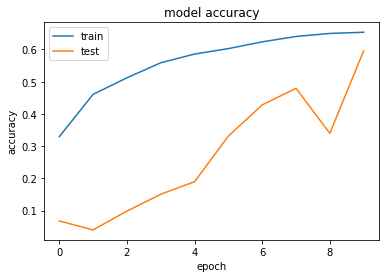

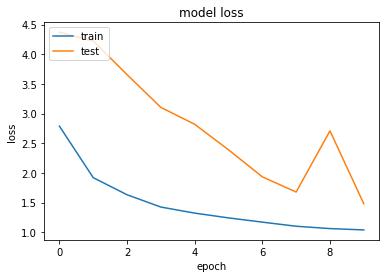

In [54]:
print(model.summary())
plot_graph(history)

In [ ]:
# make prediction using trained model
predictions = model.predict(X_test)
# calculate accuracy and other evaluation measures
y_pred = [np.argmax(prediction) for prediction in predictions]
yy_test = [list(yy).index(1) for yy in y_test]
Acc, P, R, F = make_predictions(yy_test, y_pred) 
evalution_scores.append(["ResNet", Acc, P, R, F])

# MobilenNet

In [15]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_split(train, target)
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")
print("\n shape of validation features :", X_val.shape)
print("========================================")
print("\n shape of validation labels :", y_val.shape)
print("=====================================")


shape of training features : (15155, 200, 200, 3)

 shape of training labels : (15155, 81)

 shape of testing features : (2159, 200, 200, 3)

 shape of testing labels : (2159, 81)

 shape of validation features : (4275, 200, 200, 3)

 shape of validation labels : (4275, 81)


In [16]:
input_t = tf.keras.Input(shape=(200, 200, 3))
mobile_model = tf.keras.applications.MobileNet(include_top=False,
                                    weights="imagenet",
                                    input_tensor=input_t,
                                              input_shape= (200, 200, 3))

for layer in mobile_model.layers[:143]:
    layer.trainable = False

to_res = (224, 224)
model = tf.keras.models.Sequential()  
model.add(mobile_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(81, activation='softmax'))

In [10]:
check_point = tf.keras.callbacks.ModelCheckpoint(filepath="cifar10.h5",
                                          monitor="val_acc  ",
                                          mode="max",
                                          save_best_only=True,
                                          )

model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=[check_point])

Epoch 1/10
60/60 [==============================] - 209s 3s/step - loss: 2.3420 - accuracy: 0.4054 - val_loss: 1.6888 - val_accuracy: 0.5497
Epoch 2/10
60/60 [==============================] - 208s 3s/step - loss: 1.3704 - accuracy: 0.6207 - val_loss: 1.2951 - val_accuracy: 0.6108
Epoch 3/10
60/60 [==============================] - 208s 3s/step - loss: 1.1006 - accuracy: 0.6774 - val_loss: 1.1318 - val_accuracy: 0.6653
Epoch 4/10
60/60 [==============================] - 219s 4s/step - loss: 0.9694 - accuracy: 0.7093 - val_loss: 1.0221 - val_accuracy: 0.7029
Epoch 5/10
60/60 [==============================] - 204s 3s/step - loss: 0.8899 - accuracy: 0.7249 - val_loss: 0.9748 - val_accuracy: 0.7130
Epoch 6/10
60/60 [==============================] - 252s 4s/step - loss: 0.8374 - accuracy: 0.7372 - val_loss: 0.9407 - val_accuracy: 0.7165
Epoch 7/10
60/60 [==============================] - 202s 3s/step - loss: 0.7984 - accuracy: 0.7433 - val_loss: 0.8975 - val_accuracy: 0.7186
Epoch 8/10
60

In [ ]:
print(model.summary())
plot_graph(history)

In [ ]:
# make prediction using trained model
predictions = model.predict(X_test)
# calculate accuracy and other evaluation measures
y_pred = [np.argmax(prediction) for prediction in predictions]
yy_test = [list(yy).index(1) for yy in y_test]
Acc, P, R, F = make_predictions(yy_test, y_pred) 
evalution_scores.append(["MobileNet", Acc, P, R, F])

# customize model

In [17]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_split(train, target)
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")
print("\n shape of validation features :", X_val.shape)
print("========================================")
print("\n shape of validation labels :", y_val.shape)
print("=====================================")


shape of training features : (15155, 200, 200, 3)

 shape of training labels : (15155, 81)

 shape of testing features : (2159, 200, 200, 3)

 shape of testing labels : (2159, 81)

 shape of validation features : (4275, 200, 200, 3)

 shape of validation labels : (4275, 81)


In [18]:
input_t = tf.keras.Input(shape=(200, 200, 3))
mobile_model = tf.keras.applications.MobileNet(include_top=False,
                                    weights="imagenet",
                                    input_tensor=input_t,
                                              input_shape= (200, 200, 3))

for layer in mobile_model.layers[:143]:
    layer.trainable = False

to_res = (224, 224)
model = tf.keras.models.Sequential()  
model.add(mobile_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(81, activation='softmax'))

In [19]:
check_point = tf.keras.callbacks.ModelCheckpoint(filepath="cifar10.h5",
                                          monitor="val_acc  ",
                                          mode="max",
                                          save_best_only=True,
                                          )

model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=[check_point])

Epoch 1/10
60/60 [==============================] - 211s 4s/step - loss: 2.2882 - accuracy: 0.6200 - val_loss: 3.7305 - val_accuracy: 0.3588
Epoch 2/10
60/60 [==============================] - 211s 4s/step - loss: 1.6104 - accuracy: 0.7481 - val_loss: 3.1686 - val_accuracy: 0.6182
Epoch 3/10
60/60 [==============================] - 215s 4s/step - loss: 1.4226 - accuracy: 0.7673 - val_loss: 2.5940 - val_accuracy: 0.6996
Epoch 4/10
60/60 [==============================] - 213s 4s/step - loss: 1.3097 - accuracy: 0.7784 - val_loss: 2.0840 - val_accuracy: 0.7261
Epoch 5/10
60/60 [==============================] - 212s 4s/step - loss: 1.2253 - accuracy: 0.7859 - val_loss: 1.7066 - val_accuracy: 0.7443
Epoch 6/10
60/60 [==============================] - 215s 4s/step - loss: 1.1670 - accuracy: 0.7871 - val_loss: 1.4928 - val_accuracy: 0.7558
Epoch 7/10
60/60 [==============================] - 214s 4s/step - loss: 1.1150 - accuracy: 0.7933 - val_loss: 1.3282 - val_accuracy: 0.7670
Epoch 8/10
60

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 6, 6, 1024)        3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 36864)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 36864)             147456    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               9437440   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)              

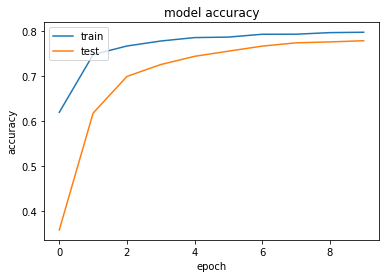

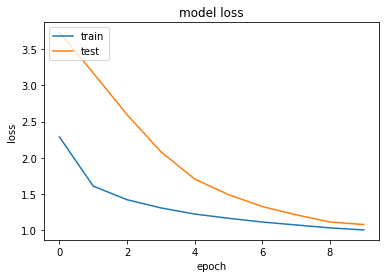

In [22]:
print(model.summary())
print("\n===================================\n")
plot_graph(history)

In [29]:
# make prediction using trained model
predictions = model.predict(X_test)
# calculate accuracy and other evaluation measures
y_pred = [np.argmax(prediction) for prediction in predictions]
yy_test = [list(yy).index(1) for yy in y_test]
Acc, P, R, F = make_predictions(yy_test, y_pred) 
evalution_scores.append(["Customize", Acc, P, R, F])

Accuracy Score : 0.7717

Precision Score : 0.7652

Recall Score : 0.7717

F1 Score : 0.7454

